In [1]:
# !poetry run pip install -U git+https://github.com/ichko/aesthetic-tensor

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

In [2]:
from aesthetic_tensor import monkey_patch_torch
monkey_patch_torch()

In [3]:
from nca.utils import conv_same

In [140]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 5
        hid = 5

        self.seed = nn.Parameter(torch.rand(64, 64) * 0.01 - 0.005)
        self.kernel = nn.Sequential(
            conv_same(1, perc, ks=5, bias=True),
            nn.ReLU(),
        )

        self.rule = nn.Sequential(
            conv_same(perc, hid, ks=1, bias=True),
            nn.ReLU(),
            conv_same(hid, 1, ks=1, bias=True),
        )

        for p in self.kernel.parameters():
            nn.init.uniform_(p, -0.5, 0.5)
        for p in list(self.rule.parameters()):
            nn.init.uniform_(p, -0.5, 0.5)
        nn.init.zeros_(self.rule[-1].bias)

    def forward(self, x, steps):
        seq = [x]
        dt = 0.6
        for i in range(steps):
            in_x = x
            in_x += (torch.rand(64, 64).to(self.seed.device) - 0.5) / 5
            in_x *= (torch.rand(64, 64).to(self.seed.device) > 0.01)
            in_x += self.seed
            perc = self.kernel(in_x)
            x = self.rule(perc) * 0.2 + x * 0.8
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [148]:
nca = SimpleNCA()
inp = torch.randn(3, 1, 64, 64)
out = nca(inp, steps=100)


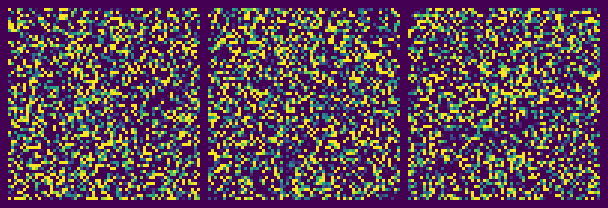

In [149]:
out.ae.zoom(3).grid(ncols=3, pad=4)[:, 0].gif(fps=15)

In [143]:
np_out = np.asarray(out.detach())[0, :, 0]
np_out.shape

(101, 64, 64)

In [97]:
import fastplotlib as fpl

In [98]:
video = np.random.rand(10, 12, 100, 100, 3)

In [151]:
iw_video = fpl.ImageWidget(np_out, figure_kwargs={"size": (700, 500)}, cmap="viridis")
iw_video.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(css_height='500px', css_width='700px'), IpywidgetToolBar(chil…

In [123]:
plot = fpl.Plot(camera="3d")

plot.add_volume(voldata)

plot.show()

TypeError: Figure.__init__() got an unexpected keyword argument 'camera'